In [57]:
from netCDF4 import Dataset
import xarray as xr
import georasters as gr
import matplotlib.pyplot as plt
import wrf
from wrf import getvar, interpline, CoordPair, xy_to_ll, ll_to_xy
import numpy as np
import seaborn as sns
from osgeo import gdal_array, gdal, osr

In [58]:
filename = '/opt/wrfdatos/wrfout/2020_01/wrfout_A_d01_2020-01-09_06:00:00'
ncwrf = Dataset(filename)
#ds = xr.open_dataset(filename)

In [59]:
import os

PROG_VERSION = 'v0.1.0'

#WRF_VARIABLES = ['T2', 'TSK', 'wspd10', 'wdir10']
WRF_VARIABLES = ['RAINNC']

WRFOUT_REGEX = r"wrfout_(?P<param>[A-Z])_[a-z0-9]{3,4}_(?P<timestamp>\d{4}-\d{2}-\d{2}_\d{2}:\d{2}:\d{2})"

CBA_EXTENT = [-67.0,
              -35.3,
              -60.7,
              -29.0]

WRF_EXTENT = [-538001.0623448786,
              -538000.0000000792,
              537998.9376551214,
              537999.9999999208]

# recorte para graphs de ppnaccum
RECORTE_EXTENT = [-66.07031,
                  -35.168794,
                  -61.579685,
                  -29.328177]

KM_PER_DEGREE = 111.32
RESOLUTION = 4

def cambiar_projection(in_array: np.ndarray):
    """Convert Grid to New Projection.
        Parameters
        ----------
        in_array
    """
    # WRF Spatial Reference System
    source_prj = osr.SpatialReference()
    source_prj.ImportFromProj4('+proj=lcc +lat_0=-32.500008 +lon_0=-62.7 '
                               '+lat_1=-60 +lat_2=-30 +x_0=0 +y_0=0 +R=6370000'
                               ' +units=m +no_defs')
    # Lat/lon WSG84 Spatial Reference System
    target_prj = osr.SpatialReference()
    target_prj.ImportFromProj4('+proj=longlat +ellps=WGS84 '
                               '+datum=WGS84 +no_defs')

    # se configura la matriz destino
    sizex = int(((CBA_EXTENT[2] - CBA_EXTENT[0]) * KM_PER_DEGREE) / RESOLUTION)
    sizey = int(((CBA_EXTENT[3] - CBA_EXTENT[1]) * KM_PER_DEGREE) / RESOLUTION)

    out_array = np.ndarray(shape=(int(in_array.coords['Time'].count()),
                           sizey, sizex))

    for t in range(in_array.coords['Time'].size):
        # loar gdal array y se le asigna la projección y transofrmación
        raw = gdal_array.OpenArray(np.flipud(in_array[t].values))
        raw.SetProjection(source_prj.ExportToWkt())
        raw.SetGeoTransform(getGeoT(WRF_EXTENT,
                                    raw.RasterYSize,
                                    raw.RasterXSize))

        grid = gdal.GetDriverByName('MEM').Create("tmp_ras",
                                                  sizex, sizey, 1,
                                                  gdal.GDT_Float32)
        # Setup projection and geo-transformation
        grid.SetProjection(target_prj.ExportToWkt())
        grid.SetGeoTransform(getGeoT(CBA_EXTENT,
                                     grid.RasterYSize,
                                     grid.RasterXSize))

        # reprojectamos
        gdal.ReprojectImage(raw,
                            grid,
                            source_prj.ExportToWkt(),
                            target_prj.ExportToWkt(),
                            gdal.GRA_NearestNeighbour,
                            options=['NUM_THREADS=ALL_CPUS'])

        out_array[t] = grid.ReadAsArray()

    return out_array, grid.GetGeoTransform(), grid.GetProjection()

def getGeoT(extent, nlines, ncols):
    # Compute resolution based on data dimension
    resx = (extent[2] - extent[0]) / ncols
    resy = (extent[3] - extent[1]) / nlines
    return [extent[0], resx, 0, extent[3], 0, -resy]

In [60]:
variable = 'RAINNC'
var = wrf.getvar(ncwrf, variable, timeidx=wrf.ALL_TIMES)
varNC = wrf.getvar(ncwrf, 'RAINC', timeidx=wrf.ALL_TIMES)
var.values = var.values + varNC.values

var_proj, geoTransform, target_prj = cambiar_projection(var)
#base_path = f"{path_gtiff}{configuracion}_{variable}"
print(var.values.shape)

(58, 269, 269)


In [61]:
# elegir la hora del wrfout
hora = 12
hora = hora - 6

wrfout completo: 


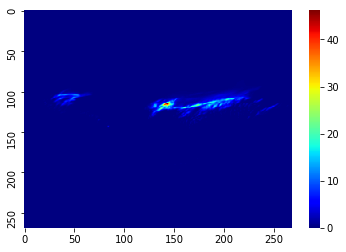

In [62]:
print("wrfout completo: ")
ax = sns.heatmap(var.values[hora], cmap='jet', xticklabels=50, yticklabels=50)

In [63]:
arr = np.zeros((58,175,175))

for t in range(ncwrf.dimensions['Time'].size):
    arr[t] = var_proj[t] - var_proj[t-3]

(58, 175, 175)


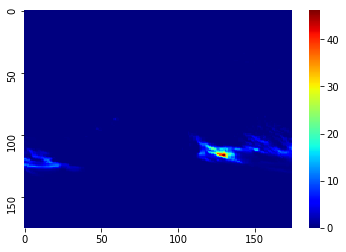

In [64]:
print(arr.shape)
ax = sns.heatmap(arr[hora], cmap='jet', xticklabels=50, yticklabels=50)

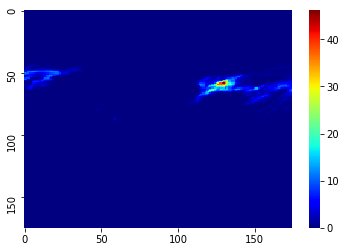

In [65]:
ax = sns.heatmap(np.flipud(arr[hora]), cmap='jet', xticklabels=50, yticklabels=50)

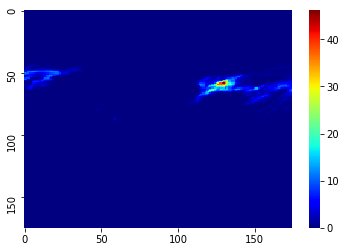

In [66]:
nombre = '/opt/datos/wrf-meteo/geotiff/2020_01/09/useful_CBA_A_06_RAINNC_2020-01-09T12:00.tiff'
tiff = gr.from_file(nombre).to_pandas()['value'].to_numpy().reshape(175,175)
#ax = sns.heatmap(tiff, cmap='jet', xticklabels=50, yticklabels=50)
ax = sns.heatmap(np.flipud(tiff), cmap='jet', xticklabels=50, yticklabels=50)

In [68]:
np.array_equal(np.flipud(arr[hora]), np.flipud(tiff))

True

## Lat Lon del punto donde mas llovio

In [72]:
tiff=np.flipud(tiff)

In [83]:
print(f'pixel donde mas llovio: {np.where(tiff == tiff.max())}')
print(tiff[np.where(tiff == tiff.max())[0][0], np.where(tiff == tiff.max())[1][0]], " milimetros")
#print(np.where(arr[9] == arr[9].max()))
#print(arr[9, 102, 28])

#print(f'pixel donde mas llovio en wrfout completo: {np.where(var.values[hora] > 46.0)}')
print(f'pixel donde mas llovio en wrfout completo: {np.where(var.values[hora] == var.values[hora].max())}')
print(var.values[hora, 115, 143], " milimetros")

pixel donde mas llovio: (array([58]), array([130]))
46.142787504941225  milimetros
pixel donde mas llovio en wrfout completo: (array([115]), array([143]))
46.170254  milimetros


In [84]:
lat_lon = xy_to_ll(ncwrf, 115, 143)

print(lat_lon)

<xarray.DataArray 'latlon' (lat_lon: 2)>
array([-32.16961858, -63.5147373 ])
Coordinates:
    xy_coord  object CoordPair(x=115, y=143)
  * lat_lon   (lat_lon) <U3 'lat' 'lon'


In [85]:
fila = np.where(tiff == tiff.max())[0][0]
col = np.where(tiff == tiff.max())[1][0]
print("fila ", fila)
print("col ", col)

fila  58
col  130


In [86]:
fila_grados = fila * 0.036
col_grados = col * 0.036
print(fila_grados)
print(col_grados)

2.0879999999999996
4.68


In [87]:
lat = -29 - fila_grados
lat_otra = -35.3 + fila_grados
lon = -67 + col_grados
lon_otra = -60.7 - col_grados
print("LAT: ", lat)
print(lat_otra)
print("LON: ", lon)
print(lon_otra)

LAT:  -31.088
-33.211999999999996
LON:  -62.32
-65.38


In [87]:
info = gdal.Info(nombre, format='json')
#print(info)

In [103]:
driver = gdal.GetDriverByName('GTiff')
filename = '/opt/datos/wrf-meteo/geotiff/2020_01/09/useful_CBA_A_06_RAINNC_2020-01-09T12:00.tiff'
#filename = '/opt/datos/wrf-meteo/geotiff/2020_02/04/useful_CBA_A_18_RAINNC_2020-02-05T09:00.tiff'
dataset = gdal.Open(filename)
band = dataset.GetRasterBand(1)

cols = dataset.RasterXSize
rows = dataset.RasterYSize

transform = dataset.GetGeoTransform()

xOrigin = transform[0]
yOrigin = transform[3]

pixelWidth = transform[1]
pixelHeight = -transform[5]

data = band.ReadAsArray(0, 0, cols, rows)
data_flip = np.flipud(data)

points_list = [ (-63.5147373, -32.16961858), (-62.32, -31.088), (-64.19171906137967, -31.440075785594267) ] #list of X,Y coordinates

for point in points_list:
    col = int((point[0] - xOrigin) / pixelWidth)
    row = int((yOrigin - point[1] ) / pixelHeight)

    print("fila:",row," col:",col, " mm:",data_flip[row][col])

fila: 88  col: 96  mm: 0.0
fila: 58  col: 130  mm: 46.142787504941225
fila: 67  col: 78  mm: 0.0


In [ ]:
06hs--------------------09hs
10   11  11.5    13.3    15

In [196]:
filename = '/opt/wrfdatos/wrfout/2020_02/wrfout_A_d01_2020-02-05_06:00:00'
ncwrf = Dataset(filename)

lat_lon = [-31.440075785594267, -64.19171906137967]

x_y = ll_to_xy(ncwrf, lat_lon[0], lat_lon[1])

print (x_y)

<xarray.DataArray 'xy' (x_y: 2)>
array([ 99, 163])
Coordinates:
    latlon_coord  object CoordPair(lat=-31.440075785594267, lon=-64.191719061...
  * x_y           (x_y) <U1 'x' 'y'


In [200]:
variable = 'RAINNC'
var = wrf.getvar(ncwrf, variable, timeidx=wrf.ALL_TIMES)
varNC = wrf.getvar(ncwrf, 'RAINC', timeidx=wrf.ALL_TIMES)
var.values = var.values + varNC.values

hora = 12
hora = abs(hora - 6)
print(var.values.shape)
#print(var.values[9, 99, 163])
print(var.values[hora, 99, 163])

(58, 269, 269)
0.03271538


In [38]:
y_test = np.load('/opt/datos/dataset/milimetros/Y_test.npy')

In [ ]:
y_flip = np.zeros((y_test.shape[0], y_test.shape[1], y_test.shape[2]))
for k,y in enumerate(y_test):
    y_flip[k,:,:] = np.flipud(y)

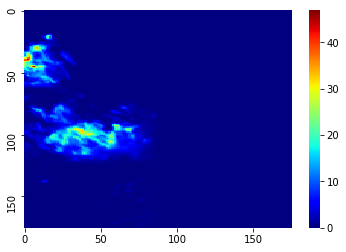

In [52]:
ax = sns.heatmap(y_test[264], cmap='jet', xticklabels=50, yticklabels=50)

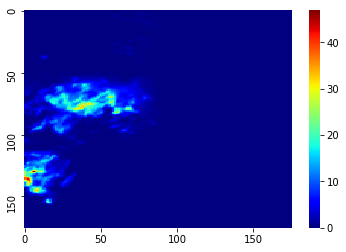

In [53]:
ax = sns.heatmap(y_flip[264], cmap='jet', xticklabels=50, yticklabels=50)

In [32]:
import pandas as pd

data1 = pd.DataFrame({'Weather': ['Sunny ',' Yin ',' Rain ',' Rain '],
                      'Reproducir': ['NO', 'SI', 'SI', 'SI']})

data1[['Weather','Reproducir']]

,Weather,Reproducir
0,Sunny,NO
1,Yin,SI
2,Rain,SI
3,Rain,SI


In [33]:
prob1 = pd.value_counts (data1 ['Reproducir']) / len (data1 ['Reproducir'])
import numpy as np
sum(np.log2(prob1)*prob1*(-1))

0.8112781244591328

In [45]:
a = pd.value_counts (data1 ['Reproducir']) / len (data1 ['Reproducir'])
print(sum(np.log2(a)*a*(-1)))
b = [0.75, 0.25]
print(sum(np.log2(b)*b*(-1)))

0.8112781244591328
0.8112781244591328


In [56]:
e1 = data1.groupby('Weather').apply(lambda x: 2 ,(data1['Reproducir']))
p1 = pd.value_counts (data1 ['weather']) / len (data1 ['Weather'])
e2 = sum(e1*p1)

TypeError: <lambda>() takes 1 positional argument but 2 were given